In [15]:
import sys

sys.path.append(".")

import os
import pickle
import numpy as np
import ipywidgets as widgets
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from skimage.filters import gaussian
from IPython.display import display
from utils import read_msi

# Define current folder using this file
CWD = "."
# Define folder that contains data
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LIVER"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

LIPID_START = 600
LIPID_END = 900
GAUSSIAN_SIGMA = 0
NUM_OF_CLUSTERS = 10

In [2]:
def plot_dendrogram(model, **kwargs):

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  labels = fcluster(linkage_matrix, kwargs.get('p', 2), criterion='maxclust')

  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)
  plt.show()

  return labels

In [3]:
files = []
for folder in PROCESSED_DATA.iterdir():
  for file in folder.iterdir():
    if 'common_representation.imzML' == file.name:
      files.append(file)
files

[PosixPath('../data/LIVER/processed/liver_opt_1/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_opt_2/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_opt_3/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_std_1/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_std_2/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_std_3/common_representation.imzML')]

In [24]:
disk(1)
img_filter.shape

(42, 79, 24000)

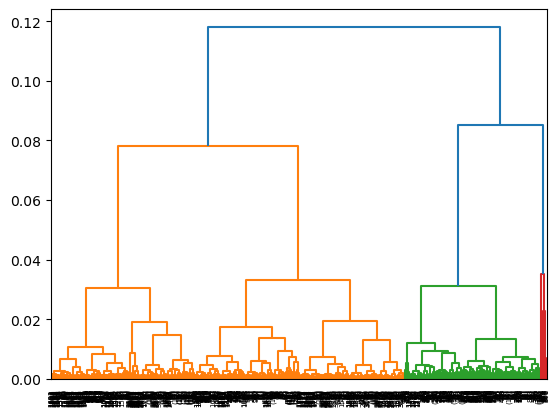

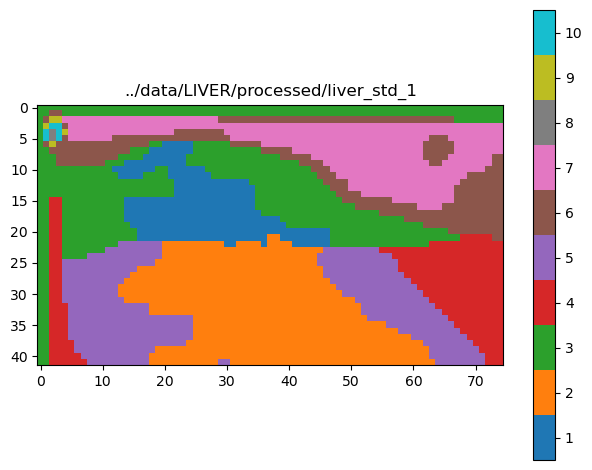

interactive(children=(SelectMultiple(description='Select Labels', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), val…

Button(description='Save Selection', icon='save', style=ButtonStyle(), tooltip='Click to save your selection o…

Selected labels saved to ../data/LIVER/processed/liver_std_1/segmentation.npy


In [29]:
from scipy import ndimage

# TODO: Update each time
load = False
file_index = 3

#
file = files[file_index]
with ImzMLParser(file) as p:
  mzs, img = read_msi(p)
  mzs_filter = (mzs >= LIPID_START) & (mzs <= LIPID_END)
  img_filter = img[:, :, mzs_filter]
  smoothed_img = ndimage.median_filter(img_filter, 3)
  flat_img = smoothed_img.reshape(-1, smoothed_img.shape[-1])
  if load:
    with open(file.parent / "hca_common_representation.pkl", 'rb') as f:
      model = pickle.load(f)
  else:
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model.fit(flat_img)
    path = file.parent / "hca_common_representation.pkl"
    with open(path, 'wb') as f:
      pickle.dump(model, f)
  labels = plot_dendrogram(model, truncate_mode="level", p=NUM_OF_CLUSTERS)
  seg = labels.reshape(smoothed_img.shape[:-1])
  seg_map = plt.imshow(seg, cmap='tab10', vmax=seg.max() + 1)
  cbar = plt.colorbar(seg_map)
  unique_labels = np.unique(seg)
  cbar.set_ticks(unique_labels + 0.5)
  cbar.set_ticklabels(unique_labels)
  plt.title(file.parent)
  plt.tight_layout()
  plt.show()


def save_selected_labels(selected_labels):
  path = file.parent / "hca_common_representation_bg_labels.npy"
  np.save(path, selected_labels)
  path = file.parent / "segmentation.npy"
  np.save(path, ~np.isin(seg, selected_labels))
  print(f"Selected labels saved to {path}")


@widgets.interact
def update_plot(
    selected_labels=widgets.SelectMultiple(
        options=unique_labels, description="Select Labels"
    )
):
  mask = np.isin(seg, selected_labels)
  plt.imshow(mask, cmap='gray')
  plt.title(f'Selected Labels: {selected_labels}')
  plt.show()


# Button for saving selected labels
button = widgets.Button(
    description='Save Selection', button_style='',
    tooltip='Click to save your selection of labels to disk', icon='save'
)

# Display the button
display(button)


# Function to capture the current selection and save it
def on_button_clicked(b):
  selected_labels = update_plot.widget.kwargs['selected_labels']
  save_selected_labels(selected_labels)


# Link the button to the action function
button.on_click(on_button_clicked)

In [ ]:
# We should remove bad chips - 3, 5, 18, 19, Look at segmentation and see others.

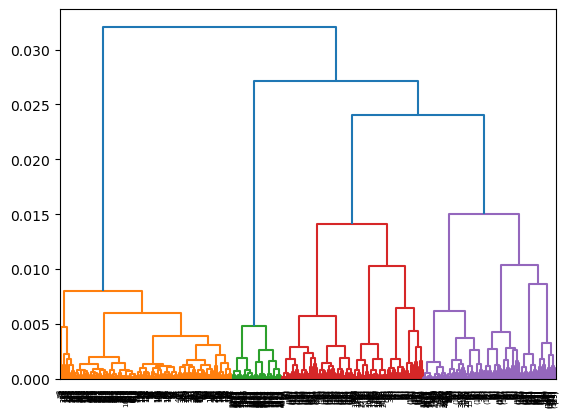

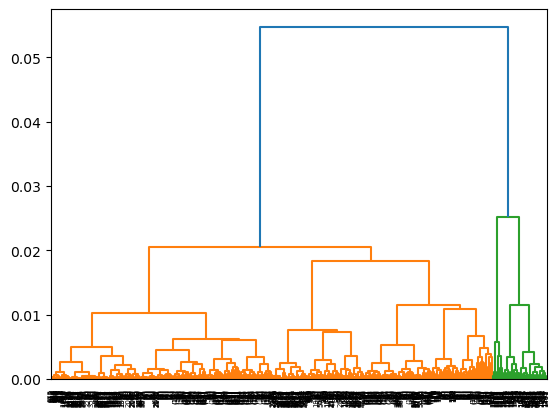

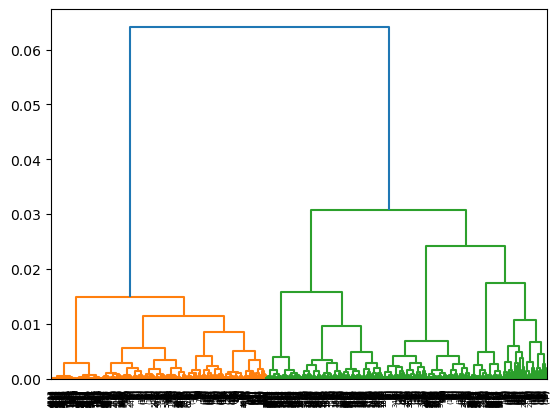

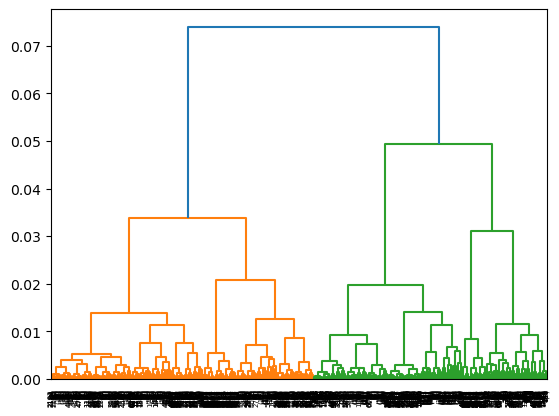

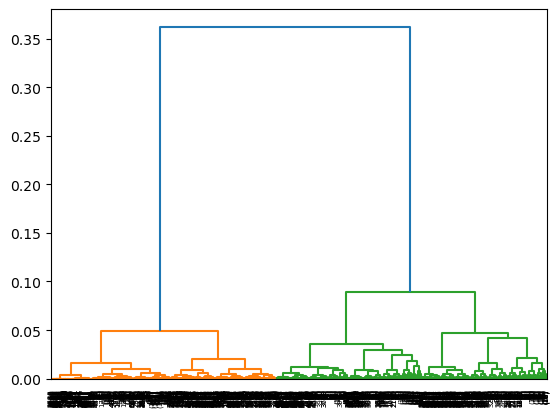

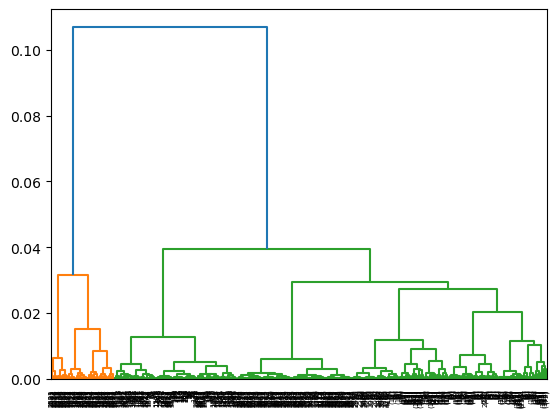

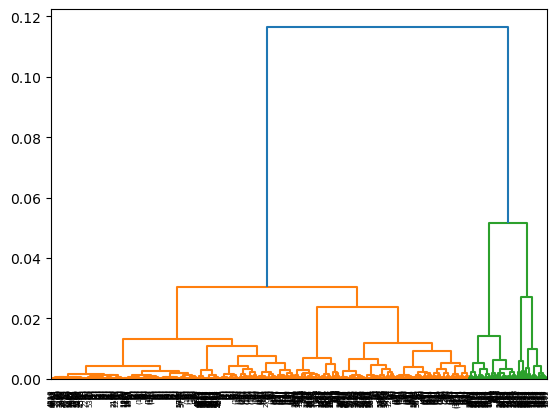

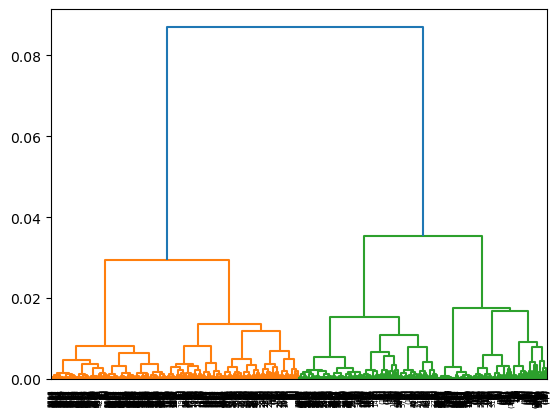

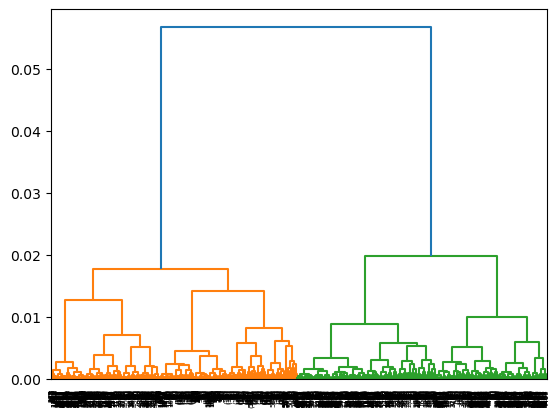

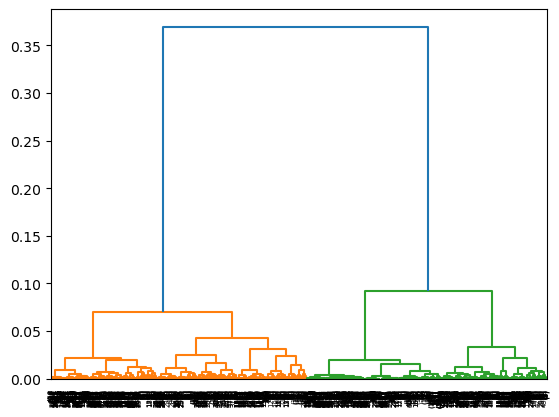

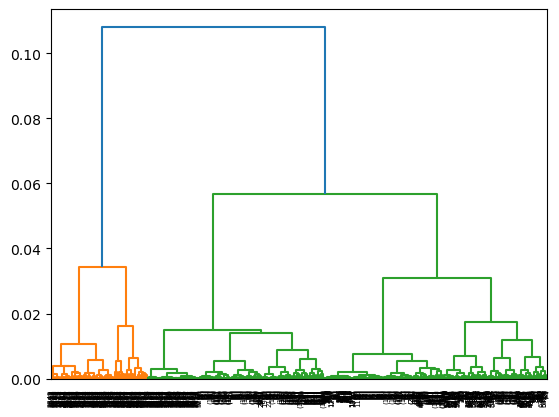

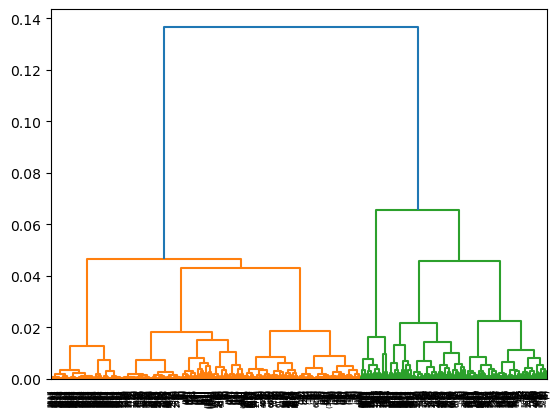

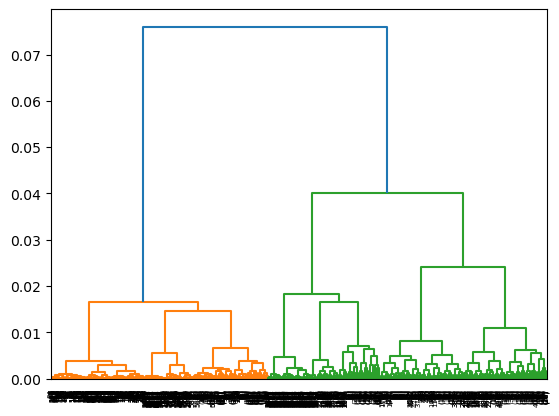

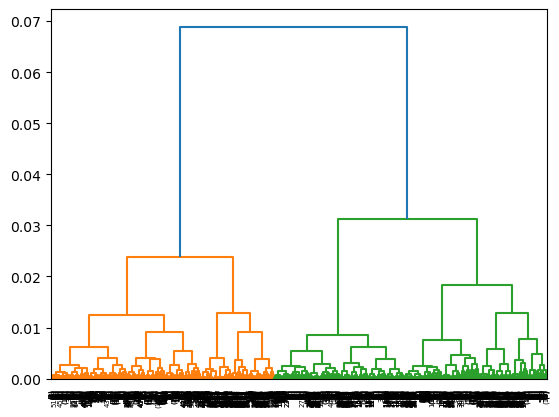

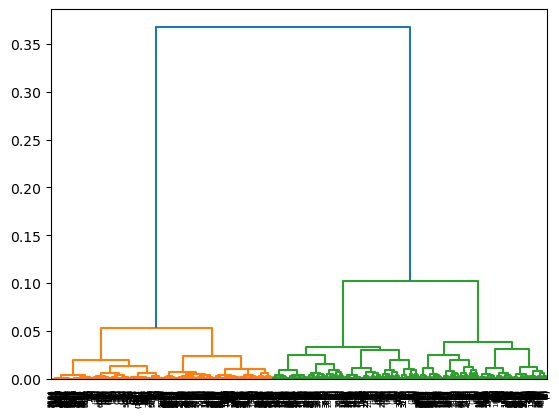

In [28]:
for folder in PROCESSED_DATA.iterdir():
  model_path = folder / "hca_common_representation.pkl"
  file = folder / "common_representation.imzML"
  selected_labels_path = folder / "hca_common_representation_bg_labels.npy"

  selected_labels = np.load(selected_labels_path, mmap_mode='r')

  with open(model_path, 'rb') as f:
    model = pickle.load(f)

  with ImzMLParser(file) as p:
    mzs, img = read_msi(p)

    labels = plot_dendrogram(model, truncate_mode="level", p=NUM_OF_CLUSTERS)
    seg = labels.reshape(img.shape[:-1])

    mask = np.isin(seg, selected_labels)

    path = file.parent / "segmentation.npy"
    np.save(path, mask)

In [26]:
selected_labels

PosixPath('../data/CHIP_TYPES_NEW/processed/1_porous_nNs_with_porous_substrate-r/hca_common_representation_bg_labels.npy')

In [36]:
from processing import ZScoreCorrection
from pyimzml.ImzMLWriter import ImzMLWriter

for folder in PROCESSED_DATA.iterdir():
  for file in folder.iterdir():
    # Parse the msi file
    if 'common_representation.imzML' == file.name:
      with ImzMLParser(file) as reader:
        # Get full msi
        mzs, img = read_msi(reader)
        # Segment image
        segment_img = np.load(file.parent / "segmentation.npy", mmap_mode='r')
        # Apply image correction
        zscore_img = ZScoreCorrection().correct(img, segment_img)

        # Open writer
        with ImzMLWriter(
            file.parent / "meaningful_signal.imzML", mode="continuous"
        ) as writer:
          # Save zscore image
          for _, (x, y, z) in enumerate(reader.coordinates):
            writer.addSpectrum(mzs, zscore_img[y - 1, x - 1], (x, y, z))

In [35]:
seg_path = PROCESSED_DATA / "liver_std_1" / "segmentation.npy"
segment_img = np.load(seg_path, mmap_mode='r')
np.save(seg_path, ~segment_img)

In [43]:
!python chip_types_data_analysis.py

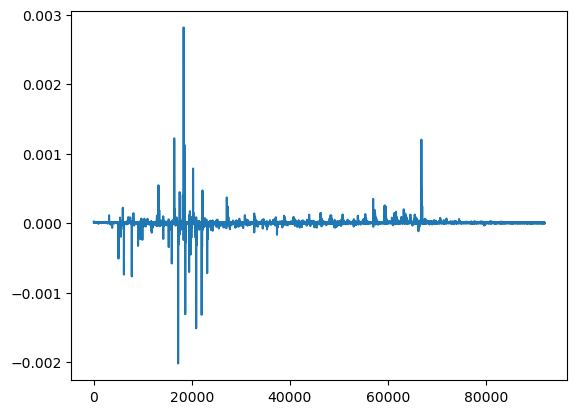

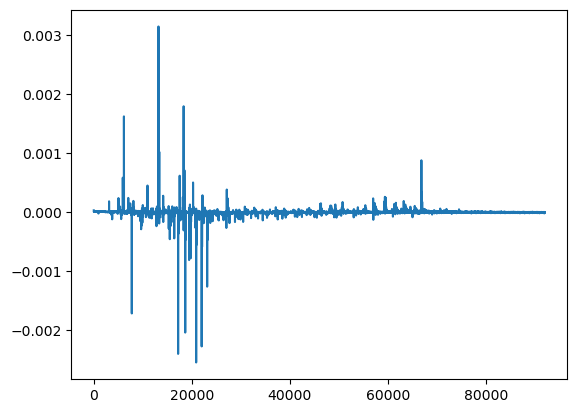

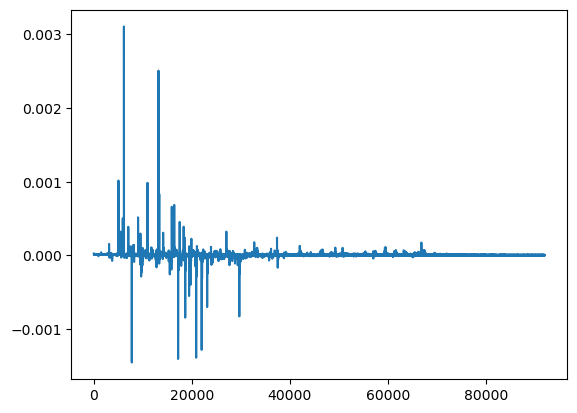

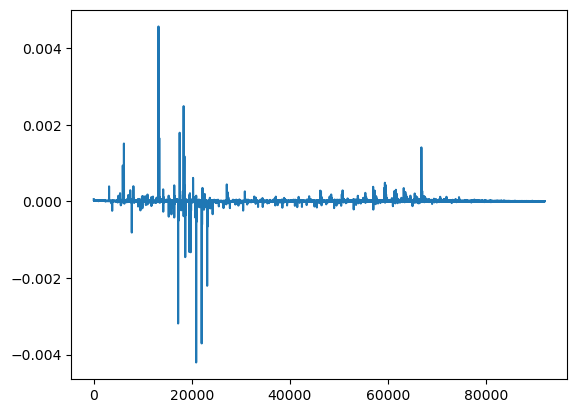

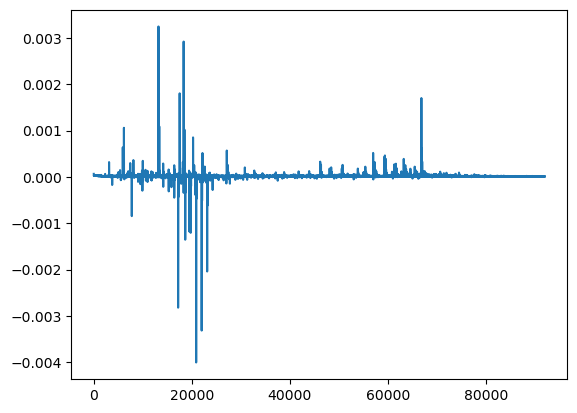

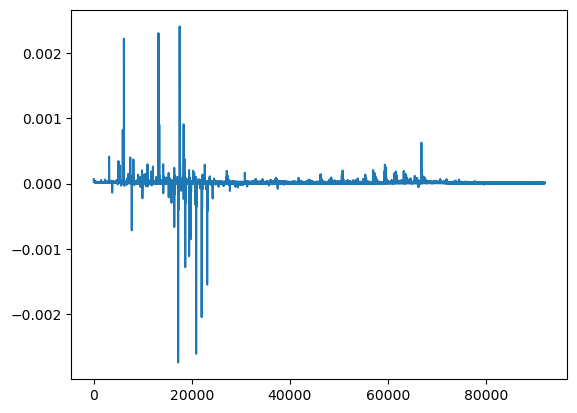

In [41]:
for folder in PROCESSED_DATA.iterdir():
  for file in folder.iterdir():
    segment_img = np.load(file.parent / "segmentation.npy", mmap_mode='r')
    # Parse the msi file
    if 'common_representation.imzML' == file.name:
      with ImzMLParser(file) as reader:
        # Get full msi
        mzs, img = read_msi(reader)

        estimated_baseline = np.median(img[~segment_img, :], axis=0)

        img_new = img - estimated_baseline

        plt.plot(np.mean(img_new[segment_img], axis=0))
        plt.show()